In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance, Angle
from astropy.table import Table, Column
from astropy.io import ascii
#import xml.etree.ElementTree as ET, urllib.request, gzip, io
%matplotlib inline

First we have to query our data from SDSS using CasJobs. Looking at the database we can see all the different parameters that are available to be queried. We will download the ones necessary to locate its position (RA, Dec, and redshift -- which will give us distance), and some properties of the galaxies, like spectro_Flux_g / r / i (flux in g / r / i band), elodieBV (BV color), and elodieFeH (metallicity). The following SQL script will select these data for us.

SELECT gz.ra,gz.dec,sp.z,sp.spectroFlux_g as g, sp.spectroFlux_r as r, 
  sp. spectroFlux_i as i, sp.elodieBV as BV, 
  sp.elodieFeH as FeH into mydb.galaxydata from DR10.zooSpec as gz 
  JOIN  DR8.specObjAll as sp on sp.specobjid=gz.specobjid
WHERE sp.zWarning=0 and sp.z >0.0005

Then download the table: galaxydata_archiekinnane.fit. This file is also on my GitHub.

In [14]:
cd Downloads

/Users/archiekinnane/Downloads


We open, inspect, and read in the data from the fits file. We see that all of our columns made it in.

In [17]:
hdu1 = fits.open("galaxydata_archiekinnane.fit")
hdu1.info()
print(hdu1[1].columns)

Filename: galaxydata_archiekinnane.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU     24   665225R x 8C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
ColDefs(
    name = 'ra'; format = '1E'
    name = 'dec'; format = '1E'
    name = 'z'; format = '1E'
    name = 'g'; format = '1E'
    name = 'r'; format = '1E'
    name = 'i'; format = '1E'
    name = 'BV'; format = '1E'
    name = 'FeH'; format = '1E'
)


Let's put it in a neat astropy Table and take a look at what we have.

In [18]:
from astropy.table import Table
galaxies = Table(hdu1[1].data)

In [19]:
galaxies

ra,dec,z,g,r,i,BV,FeH
float32,float32,float32,float32,float32,float32,float32,float32
146.86,-0.808917,0.126554,9.64814,35.3431,66.2469,0.0,0.0
146.964,-0.545028,0.0559879,9.88405,19.0224,29.3057,0.0,0.0
146.728,-0.556861,0.0893375,20.536,58.9509,95.6222,0.0,0.0
146.744,-0.652222,0.203769,9.25698,34.4419,58.6414,0.0,0.0
146.593,-0.76025,0.0650235,26.572,52.4444,75.2112,0.0,0.0
146.934,-0.670417,0.121316,25.8561,76.4256,120.614,0.0,0.0
146.95,-0.592222,0.0647767,16.542,32.7794,48.2095,0.0,0.0
146.629,-0.765139,0.0645888,30.3439,72.8277,114.546,0.0,0.0
146.858,-0.662889,0.0843962,5.83184,12.3399,17.2829,0.0,0.0


Next, we want to convert our redshifts into distances using an astropy method called Planck13.comoving_distance. 

There are a few ways to calculate distances. Lookback-time distance is how long it took the light we are seeing to reach us. Luminosity distance is the distance -- found using inverse square law -- that the galaxies would emit at their observed brightness. Comoving distances scale out the expansion of the universe. If we were able to stop the expansion of the universe and go and measure the distance to galaxies that is what we would get.

We also convert our RA (in degrees) into an RA in hours by dividing by 15, just to have it. We add these columns to our table.

In [20]:
from astropy.cosmology import Planck13
galaxies.add_column(Column(Planck13.comoving_distance(galaxies['z']),name='distance'))
galaxies.add_column(Column(galaxies['ra']/15.,name='ra_h'))

Let's check out our updated table!

In [21]:
galaxies

ra,dec,z,g,r,i,BV,FeH,distance,ra_h
,,,,,,,,Mpc,
float32,float32,float32,float32,float32,float32,float32,float32,float64,float32
146.86,-0.808917,0.126554,9.64814,35.3431,66.2469,0.0,0.0,543.076903932,9.79066
146.964,-0.545028,0.0559879,9.88405,19.0224,29.3057,0.0,0.0,244.4283336,9.79759
146.728,-0.556861,0.0893375,20.536,58.9509,95.6222,0.0,0.0,386.895434145,9.78186
146.744,-0.652222,0.203769,9.25698,34.4419,58.6414,0.0,0.0,857.573560326,9.78294
146.593,-0.76025,0.0650235,26.572,52.4444,75.2112,0.0,0.0,283.260882521,9.77285
146.934,-0.670417,0.121316,25.8561,76.4256,120.614,0.0,0.0,521.278177231,9.79561
146.95,-0.592222,0.0647767,16.542,32.7794,48.2095,0.0,0.0,282.202275943,9.79667
146.629,-0.765139,0.0645888,30.3439,72.8277,114.546,0.0,0.0,281.396444611,9.77524


We also want to create a column of coordinate distances, which will make it much easier to convert between coordinate systems later. We use the astropy method SkyCoord to create this column of objects. You can input 'locations' to SkyCoord using whatever coordinate system you currently have your data in -- for us, that means RA, Dec, and comoving distance. Then, you just have to specify what it is that you gave SkyCoord, which we do using "frame = 'icrs'", which is basically the J2000 equatorial frame -- what our RA and Dec values are referential to.

Once we make this column, we add it to our table also.

In [ ]:
galaxies.add_column(Column(SkyCoord(galaxies['ra'],galaxies['dec'],unit=(u.degree, u.degree),
                   distance=Distance(galaxies['distance'],u.pc),frame='icrs'), name = 'coords'))

(0, 1)

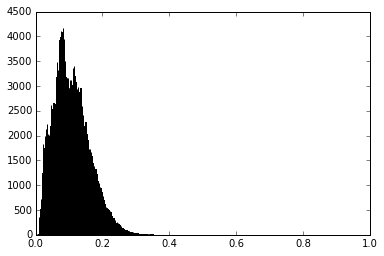

In [52]:
NBINS = 10000
redshift_hist = plt.hist(test_data['z'], NBINS)
plt.xlim(0,1)


In [56]:
max(test_data['z'])

6.9186325

(0, 10)

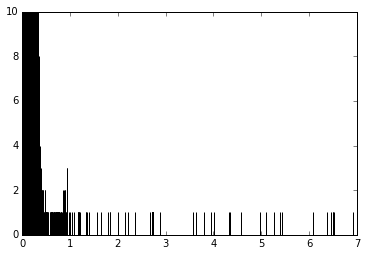

In [54]:
NBINS = 10000
redshift_hist = plt.hist(test_data['z'], NBINS)
#plt.xlim(0,1)
plt.ylim(0,10)

359.997 0.00170833
70.2689 -11.2528


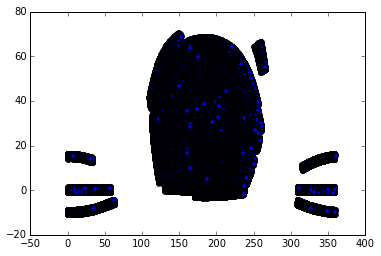

In [50]:
#import numpy as np
#from matplotlib.colors import LogNorm

#NBINS = (10,10)
plt.scatter(test_data['ra'], test_data['dec'])
#img_zero_mpl = plt.hist2d(test_data['ra'], test_data['dec'], NBINS, cmap='Spectral', norm=LogNorm())

#cbar = plt.colorbar(ticks=[1.0,3.0,6.0])
#cbar.ax.set_yticklabels(['1','3','6'])

#plt.xlabel('x')
#plt.ylabel('y')

print max(test_data['ra']), min(test_data['ra'])
print max(test_data['dec']), min(test_data['dec'])

In [62]:
from astropy.cosmology import WMAP9 as cosmo

In [63]:
cosmo.H(0)

<Quantity 69.32 km / (Mpc s)>

In [64]:
cosmo.kpc_proper_per_arcmin(3)

<Quantity 472.97709620405266 kpc / arcmin>

In [71]:
cosmo.comoving_distance(7)

<Quantity 8848.305342342208 Mpc>

In [80]:
cosmo.age(0)

<Quantity 13.768899510508358 Gyr>

In [84]:
from astropy.cosmology import Planck13